# Advanced Lane-Finding

---
## Distortion Correction

![Distortion Correction](./images/Distortion_Correction.png)


![Radial distortion](./images/Radial_distortion.png)
![Radial distortion coefficients](./images/Radial_distortion_coefficients.png)


![Tangential distortion](./images/Tangential_distortion.png)
![Tangential distortion coefficients](./images/Tangential_distortion_coefficients.png)

### Import

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Matplotlib 功能
`%matplotlib qt  # show matplotlib in interactive window`

## CH1 Finding Corners

Using Opencv functions
```python3
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (8,6), None)
img = cv2.drawChessboardCorners(img, (8,6), corners, ret)
```

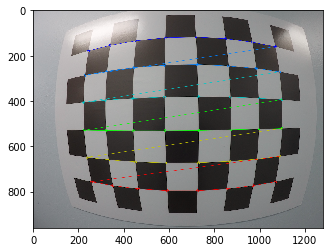

In [3]:
# prepare object points
nx = 8#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y

# Make a list of calibration images
fname = './images/calibration_test.jpg'
img = cv2.imread(fname)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)


In [4]:
np.array([corners[i] for i in [0, 7, 40, 47]])

array([[[ 244.7138 ,  178.63393]],

       [[1069.2537 ,  161.26295]],

       [[ 258.032  ,  756.28784]],

       [[1069.9795 ,  755.50964]]], dtype=float32)

## CH2 Correcting for Distortion

```python3
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)
```

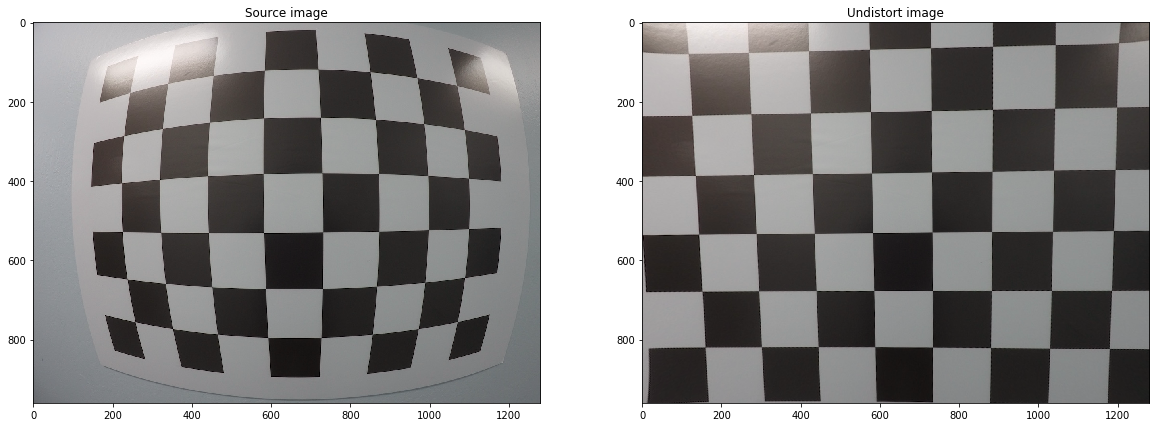

In [5]:
%matplotlib inline

# prepare object points
nx = 8
ny = 6

# Make a list of calibration images
fname = './images/calibration_test.jpg'
img = cv2.imread(fname)

# Arrays to store object points and image points from all the images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image space

# Prepare object points, like (0,0,0) (1,0,0) (2,0,0) ... (7,5,0) (x,y,z)
objp = np.zeros((6*8,3), np.float32)
objp[:,:2] = np.mgrid[0:8, 0:6].T.reshape(-1,2) # x,y,coordinates

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

ret, corners = cv2.findChessboardCorners(gray, (8,6), None)

if ret == True:
    objpoints.append(objp)
    imgpoints.append(corners)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    
    ax1.set_title('Source image')
    ax1.imshow(img)
    ax2.set_title('Undistort image')
    ax2.imshow(dst)

## More Challenge

github: https://github.com/udacity/CarND-Camera-Calibration


這裡有37張照片，收集37張的imgpoints，
並計算出Distortion Coefficients，來校正照片。

---

# Edge finding (找邊緣)
## 1. Sobel

In [17]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobelx = np.absolute(sobelx)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

## 2. Magnitude of the Gradient

In [7]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

## 3. Direction of the Gradient

In [8]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    graddir = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(graddir)
    binary_output[(graddir >= thresh[0]) & (graddir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

## 4. Combining Thresholds (結合三種方法)

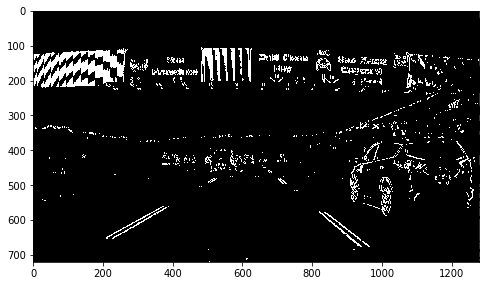

In [57]:
file = './images/signs_vehicles_xygrad.png'
image = plt.imread(file)

# parameter
ksize = 7


# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(30, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(30, 100))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(20, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
plt.figure(figsize=(8, 6))
plt.imshow(grady, cmap='gray')

---
# Color Thresholding
在灰階圖像中可以很清楚分辨白線，但遇到**黃線**時就非常不明顯，這現象我們可以從R、G、B圖觀察出來，所以使用**不同的顏色表示法可以克服這個問題**，像是HSV、HLS。

**HSV**

hue        色相

saturation 飽和度 

value      明度

**HLS**

hue        色相

lightness  亮度

saturation 飽和度

**代表意義：**

hue：與亮度變換無關的顏色值，然後加入些白色或黑色來使顏色產生亮和暗

lightness、value：代表不同方式量測顏色的亮暗度，ex:暗紅與亮紅有相同的hue值但亮度比較低

saturation：飽和度是量測多彩度，像顏色越亮(lighter)更接近白色會有低的飽和度，色彩強烈像有叫高的飽和度(bright)



## 1. Gray

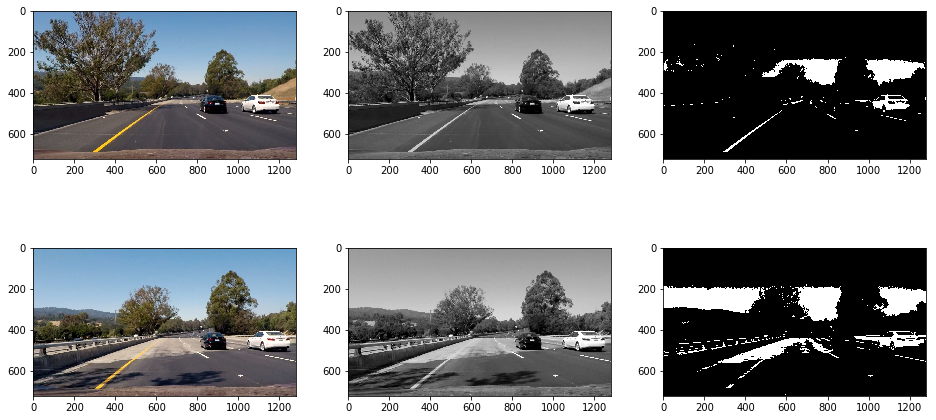

In [2]:
file1 = './images/highway_yellow_line_1.jpg'
file2 = './images/highway_yellow_line_2.jpg'
thresh = (180, 255)

image1 = plt.imread(file1)
image2 = plt.imread(file2)

gray1 = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)

gray_binary1 = np.zeros_like(gray1)
gray_binary2 = np.zeros_like(gray2)
gray_binary1[(gray1 > thresh[0]) & (gray1 <= thresh[1])] = 1
gray_binary2[(gray2 > thresh[0]) & (gray2 <= thresh[1])] = 1

plt.figure(figsize=(16,8))
plt.subplot(2,3,1)
plt.imshow(image1)
plt.subplot(2,3,2)
plt.imshow(gray1, cmap='gray')
plt.subplot(2,3,3)
plt.imshow(gray_binary1, cmap='gray')

plt.subplot(2,3,4)
plt.imshow(image2)
plt.subplot(2,3,5)
plt.imshow(gray2, cmap='gray')
plt.subplot(2,3,6)
plt.imshow(gray_binary2, cmap='gray')

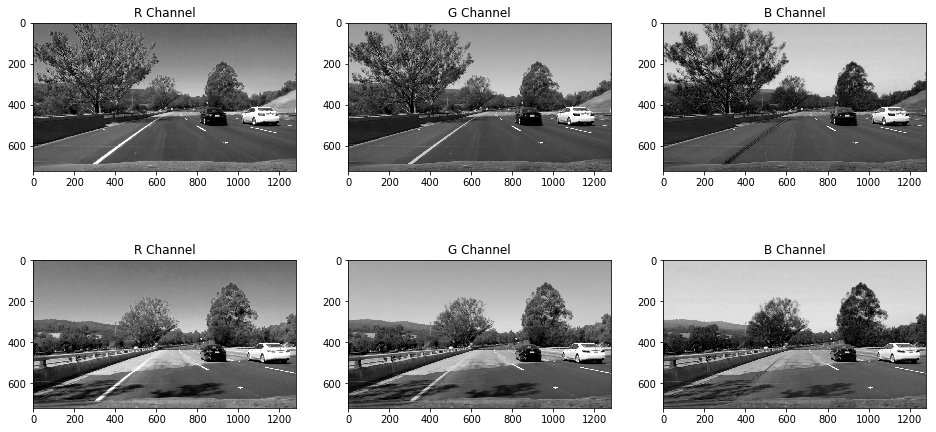

In [3]:
R1 = image1[:,:,0]
G1 = image1[:,:,1]
B1 = image1[:,:,2]
R2 = image2[:,:,0]
G2 = image2[:,:,1]
B2 = image2[:,:,2]

plt.figure(figsize=(16,8))
plt.subplot(2,3,1)
plt.title('R Channel')
plt.imshow(R1, cmap='gray')
plt.subplot(2,3,2)
plt.title('G Channel')
plt.imshow(G1, cmap='gray')
plt.subplot(2,3,3)
plt.title('B Channel')
plt.imshow(B1, cmap='gray')

plt.subplot(2,3,4)
plt.title('R Channel')
plt.imshow(R2, cmap='gray')
plt.subplot(2,3,5)
plt.title('G Channel')
plt.imshow(G2, cmap='gray')
plt.subplot(2,3,6)
plt.title('B Channel')
plt.imshow(B2, cmap='gray')

### Finding Line By R Channel
**R channel 適合用於檢測，白色和黃色的車道線都很明線**

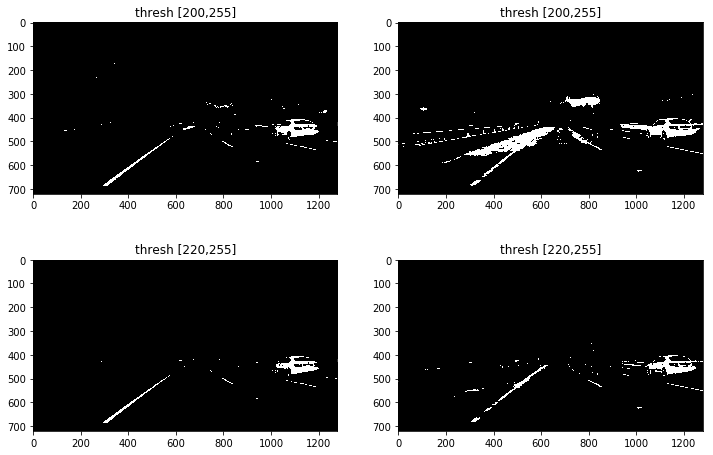

In [4]:
thresh = (200, 255)
R_binary1 = np.zeros_like(R1)
R_binary2 = np.zeros_like(R2)
R_binary1[(R1 > thresh[0]) & (R1 <= thresh[1])] = 1
R_binary2[(R2 > thresh[0]) & (R2 <= thresh[1])] = 1

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.title('thresh [200,255]')
plt.imshow(R_binary1, cmap='gray')
plt.subplot(2,2,2)
plt.title('thresh [200,255]')
plt.imshow(R_binary2, cmap='gray')

thresh = (220, 255)
R_binary3 = np.zeros_like(R1)
R_binary4 = np.zeros_like(R2)
R_binary3[(R1 > thresh[0]) & (R1 <= thresh[1])] = 1
R_binary4[(R2 > thresh[0]) & (R2 <= thresh[1])] = 1

plt.subplot(2,2,3)
plt.title('thresh [220,255]')
plt.imshow(R_binary3, cmap='gray')
plt.subplot(2,2,4)
plt.title('thresh [220,255]')
plt.imshow(R_binary4, cmap='gray')

## 2. HLS

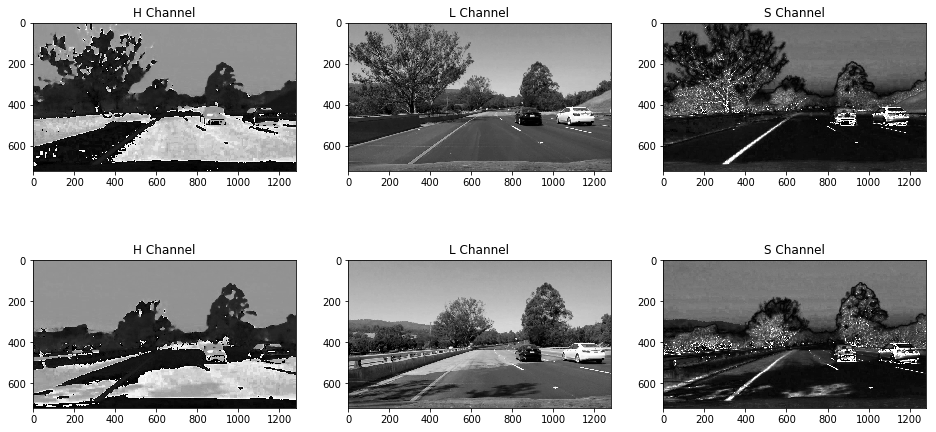

In [5]:
hls1 = cv2.cvtColor(image1, cv2.COLOR_RGB2HLS)
H1 = hls1[:,:,0]
L1 = hls1[:,:,1]
S1 = hls1[:,:,2]
hls2 = cv2.cvtColor(image2, cv2.COLOR_RGB2HLS)
H2 = hls2[:,:,0]
L2 = hls2[:,:,1]
S2 = hls2[:,:,2]

plt.figure(figsize=(16,8))
plt.subplot(2,3,1)
plt.title('H Channel')
plt.imshow(H1, cmap='gray')
plt.subplot(2,3,2)
plt.title('L Channel')
plt.imshow(L1, cmap='gray')
plt.subplot(2,3,3)
plt.title('S Channel')
plt.imshow(S1, cmap='gray')

plt.subplot(2,3,4)
plt.title('H Channel')
plt.imshow(H2, cmap='gray')
plt.subplot(2,3,5)
plt.title('L Channel')
plt.imshow(L2, cmap='gray')
plt.subplot(2,3,6)
plt.title('S Channel')
plt.imshow(S2, cmap='gray')

### Finding Line By S Channel
**S channel 可以非常清楚的把線找出來，然後我們在加入threshold**

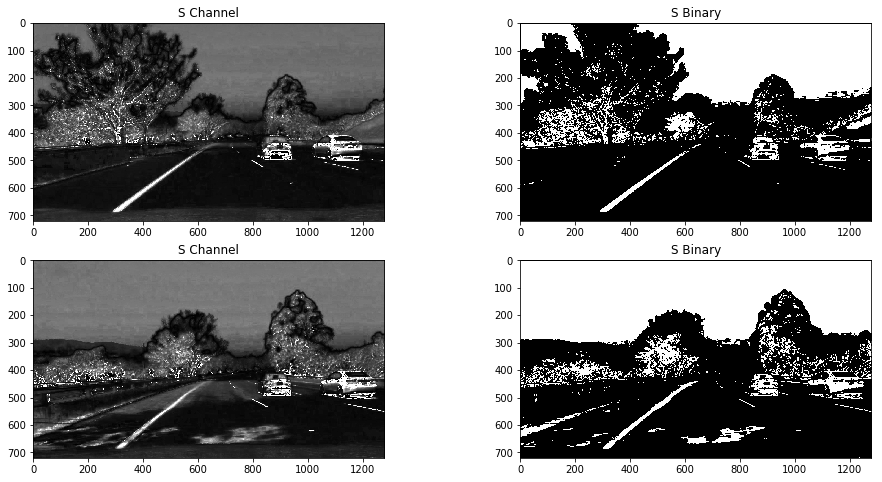

In [6]:
thresh = (90, 255)
S_binary1 = np.zeros_like(S1)
S_binary2 = np.zeros_like(S2)
S_binary1[(S1 > thresh[0]) & (S1 <= thresh[1])] = 1
S_binary2[(S2 > thresh[0]) & (S2 <= thresh[1])] = 1

plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.title('S Channel')
plt.imshow(S1, cmap='gray')
plt.subplot(2,2,2)
plt.title('S Binary')
plt.imshow(S_binary1, cmap='gray')

plt.subplot(2,2,3)
plt.title('S Channel')
plt.imshow(S2, cmap='gray')
plt.subplot(2,2,4)
plt.title('S Binary')
plt.imshow(S_binary2, cmap='gray')

### Finding Line By S Channel
**你也可以觀察到H Channel的車道明顯比較暗，可以使用較低的threshold來抓取車道**

In [47]:
((H1 > thresh[0]) & (H1 <= thresh[1])).shape

(720, 1280)

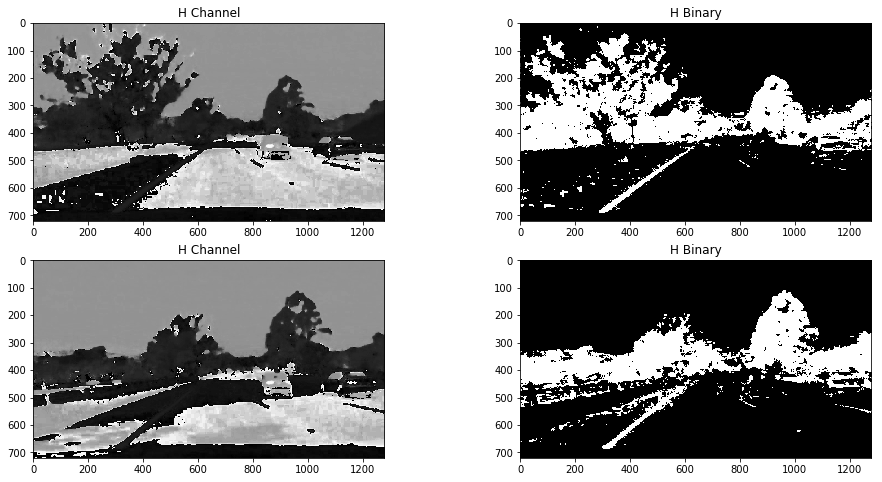

In [7]:
thresh = (15, 100)
H_binary1 = np.zeros_like(H1)
H_binary2 = np.zeros_like(H2)
H_binary1[(H1 > thresh[0]) & (H1 <= thresh[1])] = 1
H_binary2[(H2 > thresh[0]) & (H2 <= thresh[1])] = 1

plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.title('H Channel')
plt.imshow(H1, cmap='gray')
plt.subplot(2,2,2)
plt.title('H Binary')
plt.imshow(H_binary1, cmap='gray')

plt.subplot(2,2,3)
plt.title('H Channel')
plt.imshow(H2, cmap='gray')
plt.subplot(2,2,4)
plt.title('H Binary')
plt.imshow(H_binary2, cmap='gray')

### 結論
從結果來看可以看得出來**S Channel**比H Channel 和 R CHannel要來的好。

下面再顯示出所也結果：

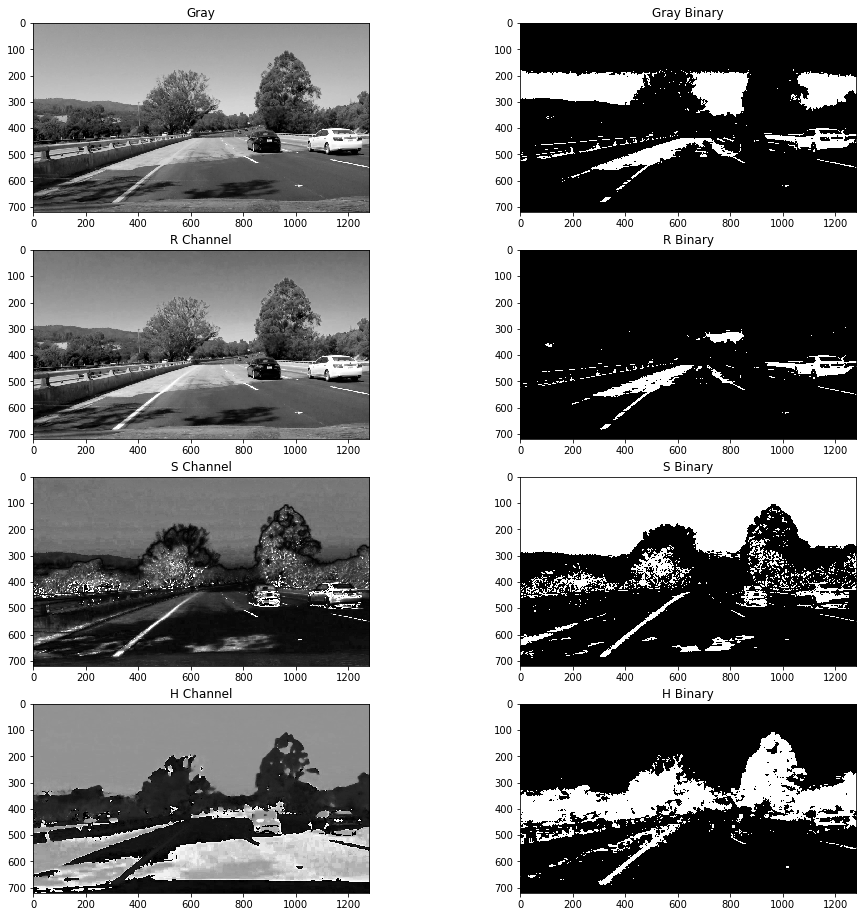

In [9]:
plt.figure(figsize=(16,16))
plt.subplot(4,2,1)
plt.title('Gray')
plt.imshow(gray2, cmap='gray')
plt.subplot(4,2,2)
plt.title('Gray Binary')
plt.imshow(gray_binary2, cmap='gray')

plt.subplot(4,2,3)
plt.title('R Channel')
plt.imshow(R2, cmap='gray')
plt.subplot(4,2,4)
plt.title('R Binary')
plt.imshow(R_binary2, cmap='gray')

plt.subplot(4,2,5)
plt.title('S Channel')
plt.imshow(S2, cmap='gray')
plt.subplot(4,2,6)
plt.title('S Binary')
plt.imshow(S_binary2, cmap='gray')

plt.subplot(4,2,7)
plt.title('H Channel')
plt.imshow(H2, cmap='gray')
plt.subplot(4,2,8)
plt.title('H Binary')
plt.imshow(H_binary2, cmap='gray')

---

## Combined Color and Gradient thresholds for lane detection
**合成顏色與邊緣找車道線的方法**
![](./images/Combined_Color_and_Gradient.png)

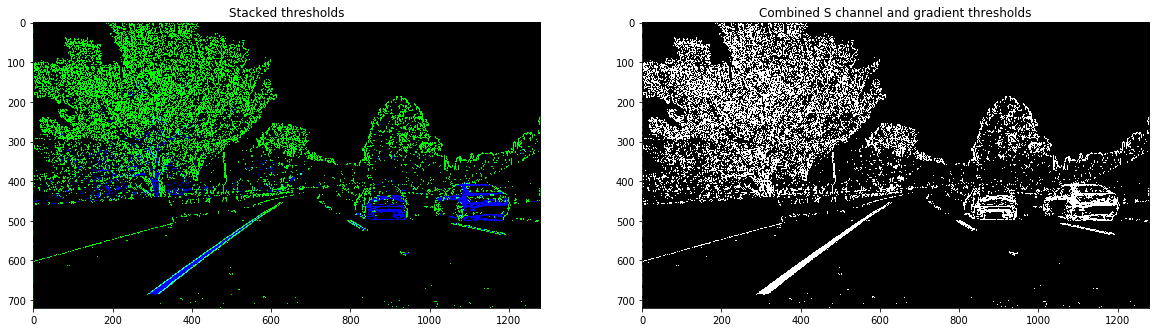

In [10]:
img = plt.imread(file1)

# Convert to HLS color space and separate the S channel
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

# Grayscale image
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack 將(Sobel x)、(Threshold color)合併並用不同顏色區分，可以讓我們更加清楚出互補的地方
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

---
# Prespective tranform

### Introdution
首先要找出四個點繪製程一個梯形正方形，你可以先假設道路是平坦的，但這**不全然正確**，但可已將做近似值的答案。

然後經過Prespective tranform，你可以從上方俯視你繪製的梯行，會如下方圖片所示，這個範例是在汽車行使在**直線上**。

![](./images/warped_straight_lines.jpg)

**轉彎道路上**

始用上面相同的方法，這次得到的**結果誤差就比較大**。
![](./images/warped_curved_lines_2.jpg)

### Locate the Lane Lines and Fit a Polynomial
首先用值方圖分析，找出基準點
```python
histogram = np.sum(img[img.shape[0]//2:,:], axis=0)    # y axis相加，並分兩次辨識
plt.plot(histogram)
```

![](./images/pixel_positoin.png)


### Sliding Windows and Fit a Polynomial
實際上可以分好幾次處理，如圖下圖所示。

![](./images/Sliding.png)

---
# Final Project
**Steps**
1. Camera calibration
2. Distortion correction
3. Color/gradient threshold
4. Perspective transform

**完成這些步驟之後，您將為該項目提供兩個附加步驟：**
1. Detect lane lines
2. Determine the lane curvature

In [15]:
x = np.array([[1,2,3],[4,5,6]])

In [16]:
np.sum(x, axis=0)

array([5, 7, 9])

In [17]:
np.argmax(x)

5

In [26]:
nonzero = gray_binary1.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

In [30]:
len(gray_binary1.nonzero()[0])

61370

In [32]:
win_y_high = 400
win_y_low = 300
win_xleft_high = 400
win_xleft_low = 300

In [38]:
good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]

In [39]:
good_left_inds.shape

(2,)